In [17]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches
from IPython.display import display



In [18]:
USE_GPU = True
TRAIN = False

In [19]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724446521.256996    4359 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724446521.258205    4359 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724446521.259577    4359 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724446521.261762    4359 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [20]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.002
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [21]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 29, 24), (2740,), (2740, 32, 32, 1))

In [22]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(32, 32, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 1, 1)        │         2,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,489 (2.67 MB)

 Trainable params: 699,489 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=4, strides=2, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 4, 4, 256)      │     4,194,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 256)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 64)       │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 16, 16, 32)     │        16,384 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 5,280,001 (20.14 MB)

 Trainable params: 5,279,105 (20.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [24]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [25]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [26]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

In [27]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

(18, 32, 32, 1)


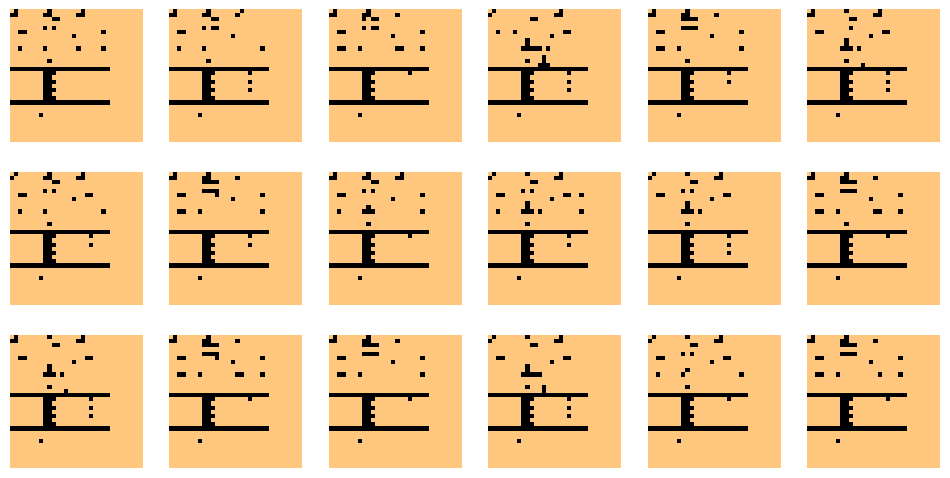

In [28]:
if TRAIN:
    
    noise = np.random.normal(size=(18, 1024))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/language_phonemes_all.npz",
        generated_languages=generated_languages,
    )

else:
    data = np.load("./data/language_phonemes_all.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

    print(generated_languages.shape)

# normalise
generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
# sigmoid
generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

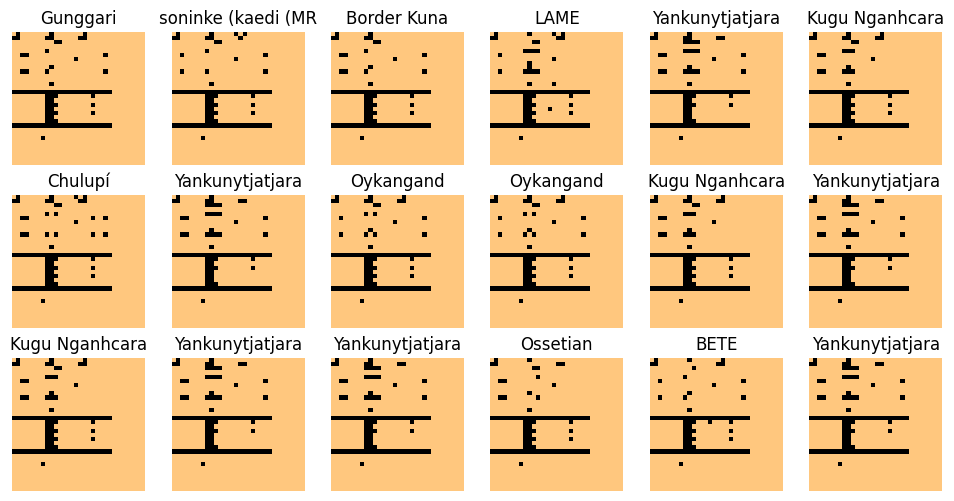

In [29]:
# find closest matches

closest_idx, closest = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

In [30]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)
display(cons_pl_tbl_df)
print(cons_pl_tbl_df.shape)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_npl_tbl_df)
print(cons_npl_tbl_df.shape)


cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(cons_coart_tbl_df)
print(cons_coart_tbl_df.shape)


vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
display(vowels_tbl_df)
print(vowels_tbl_df.shape)

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Linguolabial,Linguolabial_v,Dental,Dental_v,Alveolar,Alveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Nasal,m̥,m,ɱ̊,ɱ,,n̼,,,n̥,n,...,ɲ̊,ɲ,ŋ̊,ŋ,ɴ̥,ɴ,NaN,NaN,NaN,NaN
Plosive,p,b,p̪,b̪,t̼,d̼,,,t,d,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Sibilant affricate,NaN,NaN,NaN,NaN,NaN,NaN,,,ts,dz,...,tɕ,dʑ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-sibilant affricate,pɸ,bβ,p̪f,b̪v,,,t̪θ,d̪ð,tɹ̝̊,dɹ̝,...,cç,ɟʝ,kx,ɡɣ,qχ,ɢʁ,ʡʜ,ʡʢ,ʔh,
Sibilant fricative,NaN,NaN,NaN,NaN,NaN,NaN,,,s,z,...,ɕ,ʑ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non-sibilant fricative,ɸ,β,f,v,θ̼,ð̼,θ,ð,θ̠,ð̠,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Approximant,,,,ʋ,,,,,,ɹ,...,,j,,ɰ,,,,,,ʔ̞
Tap/flap,,ⱱ̟,,ⱱ,,ɾ̼,,,ɾ̥,ɾ,...,,,,,,ɢ̆,,ʡ̆,,
Trill,ʙ̥,ʙ,,,,,,,r̥,r,...,,,NaN,NaN,ʀ̥,ʀ,ʜ,ʢ,NaN,NaN
Fricative,ɸ,β,f,v,,,θ,ð,s,z,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ


(14, 24)


,0,1,2,3,4,5,6,7
Ejective Stop,pʼ,tʼ,ʈʼ,cʼ,kʼ,qʼ,ʡʼ,
Ejective Fricative,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ
Ejective Affricate,tsʼ,t̠ʃʼ,ʈʂʼ,kxʼ,qχʼ,,,
Ejective Lateral,ɬʼ,tɬʼ,cʎ̝̊ʼ,kʟ̝̊ʼ,,,,
Click,kʘ,kǀ,kǃ,kǂ,kǁ,,,
Implosive Voiced,ɓ,ɗ,ᶑ,ʄ,ɠ,ʛ,,
Implosive Voiceless,ɓ̥,ɗ̥,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,,


(7, 8)


,Labial–alveolar,Labial–alveolar_v,Labial–retroflex,Labial–retroflex_v,Labial–palatal,Labial–palatal_v,Labial–velar,Labial–velar_v,Labial–uvular,Labial–uvular_v,Velarized alveolar,Velarized alveolar_v,Uvular–epiglottal,Uvular–epiglottal_v,Palatal-velar,Palatal-velar_v
Nasal,,n͡m,,ɳ͡m,,,,ŋ͡m,,,,,,,,
Plosive,t͡p,d͡b,ʈ͡p,ɖ͡b,,,k͡p,ɡ͡b,q͡p,,,,q͡ʡ,,,
Fricative/approximant,,,,,ɥ̊,ɥ,ʍ,w,,,,,,,ɧ,
Lateral approximant,,,,,,,,,,,,ɫ,,,,
Implosive,,,,,,,ɠ̊͜ɓ̥,ɠ͡ɓ,,,,,,,,
Ejective,,t͡pʼ,,,,,,,,,,,,,,


(6, 16)


,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


(7, 10)


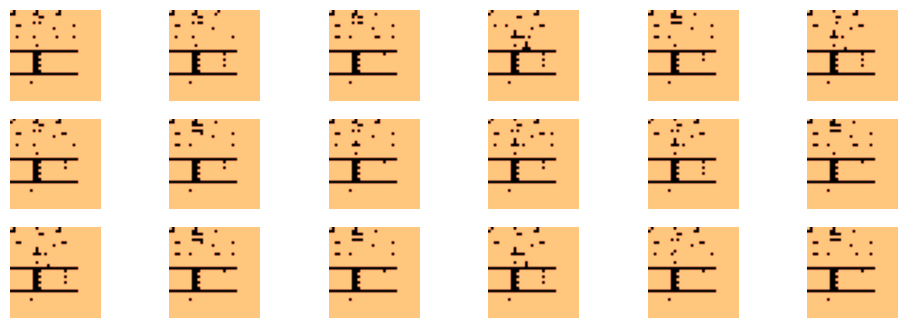

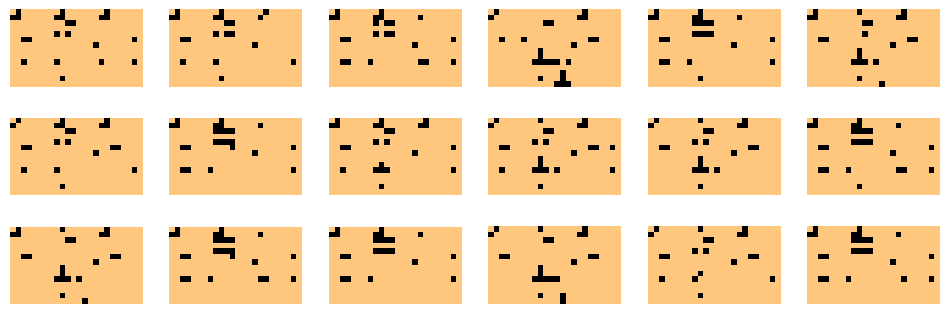

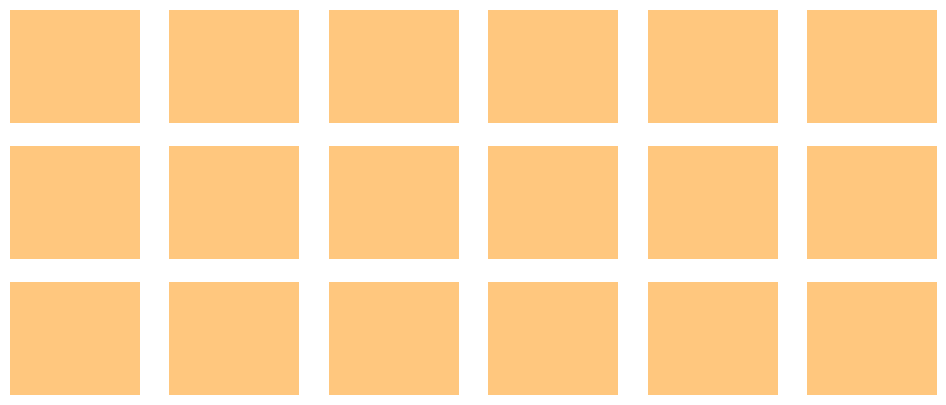

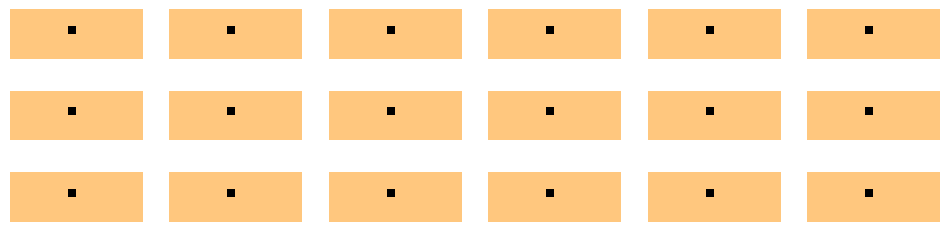

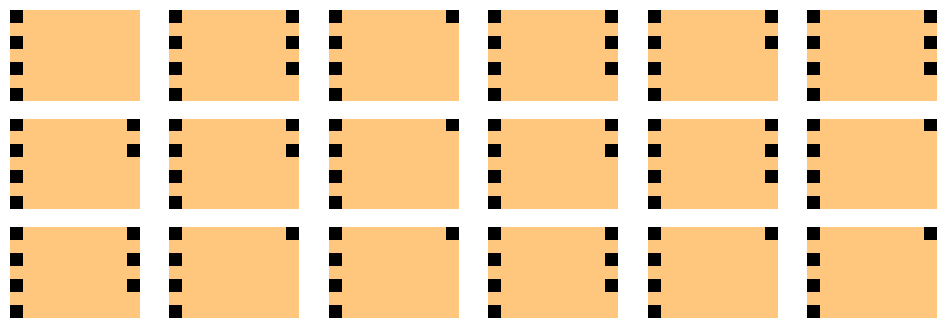

((18, 14, 24, 1), (18, 7, 8, 1), (18, 6, 16, 1), (18, 7, 10, 1))

In [31]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:8 :]
generated_vowels = generated_languages[:, 15:22, 10:20 :]
generated_cons_coart = generated_languages[:, 23:29, 0:16 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 4))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(12, 5))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(12, 3))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(12, 4))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [32]:
def create_ipa_table(lang, tbl):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    return pd.DataFrame(
        np.char.add(
            np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " ")),
            phonemes[:,1::2]
        ), 
        index=tbl.index, 
        columns=tbl.columns[0::2]
    )

sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[5]), cons_pl_tbl_df)

display(sample_cons_pl_tbl)

sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[5]), cons_npl_tbl_df)

display(sample_cons_npl_tbl)

sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[5]), cons_coart_tbl_df)

display(sample_cons_coart_tbl)

sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[5]), vowels_tbl_df)

display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ m,_ _,_ _,_ _,_ n,_ _,_ _,_ _,_ ŋ,_ _,_ _,_ _
Plosive,p b,_ _,_ _,_ _,_ _,_ _,_ _,_ _,k ɡ,_ _,_ _,_ _
Sibilant affricate,_ _,_ _,_ _,_ _,_ _,t̠ʃ d̠ʒ,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Sibilant fricative,_ _,_ _,_ _,_ _,_ _,ʃ _,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant fricative,_ _,f v,_ _,_ _,_ _,_ _,_ _,_ _,_ _,χ ʁ,_ _,_ _
Approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ j,_ _,_ _,_ _,_ _
Tap/flap,_ _,_ _,_ _,_ _,_ ɾ,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Trill,_ _,_ _,_ _,_ _,_ r,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative,_ _,_ _,_ _,_ _,s z,ʃ _,ʂ _,_ _,_ _,_ _,_ _,_ _


,0,2,4,6
Ejective Stop,_ _,_ _,_ _,_ _
Ejective Fricative,_ _,_ _,_ _,_ _
Ejective Affricate,_ _,_ _,_ _,_ _
Ejective Lateral,_ _,_ _,_ _,_ _
Click,_ _,_ _,_ _,_ _
Implosive Voiced,_ _,_ _,_ _,_ _
Implosive Voiceless,_ _,_ _,_ _,_ _


,Labial–alveolar,Labial–retroflex,Labial–palatal,Labial–velar,Labial–uvular,Velarized alveolar,Uvular–epiglottal,Palatal-velar
Nasal,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Plosive,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative/approximant,_ _,_ _,_ _,_ w,_ _,_ _,_ _,_ _
Lateral approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Implosive,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Ejective,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _


,Front unrounded,Near-front unrounded,Central unrounded,Near-back unrounded,Back unrounded
Close,i _,_ _,_ _,_ _,_ u
Near-close,_ _,_ _,_ _,_ _,_ _
Close-mid,e _,_ _,_ _,_ _,_ o
Mid,_ _,_ _,_ _,_ _,_ _
Open-mid,ɛ _,_ _,_ _,_ _,_ ɔ
Near-open,_ _,_ _,_ _,_ _,_ _
Open,a _,_ _,_ _,_ _,_ _
